# Q1: Whisper-Small Fine-Tuning on JoshTalks Hindi Data
**JoshTalks ASR Research - Ready-to-Run Colab Notebook**

## What This Does
1. Upload your `FT Data.xlsx` (104 recordings, ~22 hours of Hindi)
2. Fixes GCP URLs (old base path -> new `upload_goai` path)
3. Downloads audio + transcription from corrected URLs
4. Fine-tunes `openai/whisper-small` on this data
5. Evaluates on FLEURS Hindi test set
6. **Outputs the WER value to fill into FT Result.xlsx**

### Prerequisites
- Google Colab with **GPU runtime** (T4 or better)
- `FT Data.xlsx` file from the assignment

### Expected Time: ~40-50 minutes on T4 GPU

## Step 1: Install Dependencies and Check GPU

In [1]:
!pip install -q --upgrade transformers torch datasets==2.14.6 evaluate jiwer librosa soundfile tqdm pandas numpy matplotlib openpyxl accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires panda

In [ ]:
import torch
import json
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import requests
import librosa
import soundfile as sf
from datetime import datetime
from tqdm import tqdm
from pathlib import Path

print(f'PyTorch: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    mem_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f'GPU Memory: {mem_gb:.1f} GB')
else:
    print('WARNING: No GPU! Go to Runtime > Change runtime type > GPU')

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: Tesla T4
GPU Memory: 14.6 GB


## Step 2: Upload FT Data.xlsx
Run the cell below - it will open a file picker. Select your `FT Data.xlsx` file.

In [3]:
from google.colab import files

print('Please upload your FT Data.xlsx file:')
uploaded = files.upload()

xlsx_file = None
for fname in uploaded:
    if fname.endswith('.xlsx'):
        xlsx_file = fname
        break

if xlsx_file:
    print(f'\nLoaded: {xlsx_file}')
    df = pd.read_excel(xlsx_file, engine='openpyxl')
    print(f'Recordings: {len(df)}')
    print(f'Columns: {list(df.columns)}')
    total_hrs = df['duration'].sum() / 3600
    print(f'Total duration: {total_hrs:.1f} hours')
    display(df.head(3))
else:
    raise FileNotFoundError('No .xlsx file found in upload!')

Please upload your FT Data.xlsx file:


Saving FT Data.xlsx to FT Data.xlsx

Loaded: FT Data.xlsx
Recordings: 104
Columns: ['user_id', 'recording_id', 'language', 'duration', 'rec_url_gcp', 'transcription_url_gcp', 'metadata_url_gcp']
Total duration: 21.9 hours


,user_id,recording_id,language,duration,rec_url_gcp,transcription_url_gcp,metadata_url_gcp
0,245746,825780,hi,443,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...
1,291038,825727,hi,443,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...
2,246004,988596,hi,475,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...,https://storage.googleapis.com/joshtalks-data-...


## Step 3: Fix GCP URLs and Download Data

The original URLs use `joshtalks-data-collection/hq_data/hi/` which no longer works.
Per the task instructions, we replace the base path with `upload_goai/`.

**Example:**
- Old: `https://storage.googleapis.com/joshtalks-data-collection/hq_data/hi/967179/825780_audio.wav`
- New: `https://storage.googleapis.com/upload_goai/967179/825780_audio.wav`

In [4]:
OLD_BASE = 'storage.googleapis.com/joshtalks-data-collection/hq_data/hi/'
NEW_BASE = 'storage.googleapis.com/upload_goai/'

def fix_url(url):
    if pd.isna(url) or not isinstance(url, str):
        return None
    url = str(url).strip()
    if OLD_BASE in url:
        url = url.replace(OLD_BASE, NEW_BASE)
    return url

# Fix all URL columns
url_cols = ['rec_url_gcp', 'transcription_url_gcp', 'metadata_url_gcp']
for col in url_cols:
    if col in df.columns:
        df[col + '_fixed'] = df[col].apply(fix_url)

# Show example
print('URL Fix Examples:')
if 'rec_url_gcp' in df.columns:
    print(f'  Old: {df["rec_url_gcp"].iloc[0]}')
    print(f'  New: {df["rec_url_gcp_fixed"].iloc[0]}')
print()
if 'transcription_url_gcp' in df.columns:
    print(f'  Old: {df["transcription_url_gcp"].iloc[0]}')
    print(f'  New: {df["transcription_url_gcp_fixed"].iloc[0]}')

URL Fix Examples:
  Old: https://storage.googleapis.com/joshtalks-data-collection/hq_data/hi/967179/825780_audio.wav
  New: https://storage.googleapis.com/upload_goai/967179/825780_audio.wav

  Old: https://storage.googleapis.com/joshtalks-data-collection/hq_data/hi/967179/825780_transcription.json
  New: https://storage.googleapis.com/upload_goai/967179/825780_transcription.json


In [5]:
DATA_DIR = '/content/ft_data'
AUDIO_DIR = os.path.join(DATA_DIR, 'audio')
TRANS_DIR = os.path.join(DATA_DIR, 'transcriptions')
os.makedirs(AUDIO_DIR, exist_ok=True)
os.makedirs(TRANS_DIR, exist_ok=True)

def download_file(url, save_path, timeout=120):
    try:
        if not url or not str(url).startswith('http'):
            return False
        resp = requests.get(str(url), timeout=timeout, stream=True)
        if resp.status_code == 200:
            with open(save_path, 'wb') as f:
                for chunk in resp.iter_content(8192):
                    f.write(chunk)
            return os.path.getsize(save_path) > 100
        else:
            return False
    except Exception as e:
        return False

results = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc='Downloading'):
    rec_id = str(int(row['recording_id']))
    user_id = str(int(row['user_id']))

    audio_path = os.path.join(AUDIO_DIR, f'{rec_id}.wav')
    trans_path = os.path.join(TRANS_DIR, f'{rec_id}.json')

    # Use fixed URLs
    audio_url = row.get('rec_url_gcp_fixed', None)
    trans_url = row.get('transcription_url_gcp_fixed', None)

    audio_ok = os.path.exists(audio_path) and os.path.getsize(audio_path) > 100
    if not audio_ok:
        audio_ok = download_file(audio_url, audio_path)

    trans_ok = os.path.exists(trans_path) and os.path.getsize(trans_path) > 10
    if not trans_ok:
        trans_ok = download_file(trans_url, trans_path)

    results.append({
        'recording_id': rec_id,
        'user_id': user_id,
        'duration': row.get('duration', 0),
        'audio_path': audio_path if audio_ok else None,
        'trans_path': trans_path if trans_ok else None,
        'audio_ok': audio_ok,
        'trans_ok': trans_ok,
    })

dl_df = pd.DataFrame(results)
both_ok = (dl_df['audio_ok'] & dl_df['trans_ok']).sum()
audio_only = dl_df['audio_ok'].sum()
trans_only = dl_df['trans_ok'].sum()
print(f'\nAudio downloaded: {audio_only}/{len(df)}')
print(f'Transcriptions downloaded: {trans_only}/{len(df)}')
print(f'Both available: {both_ok}/{len(df)}')

dl_df = dl_df[dl_df['audio_ok'] & dl_df['trans_ok']].reset_index(drop=True)
print(f'\nUsing {len(dl_df)} recordings for training')

if len(dl_df) == 0:
    raise RuntimeError('No recordings downloaded! Check if URLs are accessible.')

Downloading: 100%|██████████| 104/104 [14:54<00:00,  8.60s/it]


Audio downloaded: 104/104
Transcriptions downloaded: 104/104
Both available: 104/104

Using 104 recordings for training


## Step 4: Extract Transcription Text and Build Training Data

In [6]:
def normalize_text(text):
    text = unicodedata.normalize('NFKC', text)
    text = text.replace('\u200b', '').replace('\u200c', '').replace('\u200d', '')
    text = re.sub(r'[^\w\s\u0900-\u097F]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_transcription(json_path):
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        if isinstance(data, str):
            return normalize_text(data)
        elif isinstance(data, dict):
            for key in ['text', 'transcription', 'transcript', 'content']:
                if key in data:
                    return normalize_text(str(data[key]))
            if 'segments' in data:
                texts = [s.get('text', '') for s in data['segments']]
                return normalize_text(' '.join(texts))
            for v in data.values():
                if isinstance(v, str) and len(v) > 5:
                    return normalize_text(v)
        elif isinstance(data, list):
            if data and isinstance(data[0], dict):
                texts = [item.get('text', '') for item in data]
                return normalize_text(' '.join(texts))
            return normalize_text(' '.join(str(x) for x in data))
    except Exception as e:
        print(f'  Error reading {json_path}: {e}')
    return None

samples = []
for idx, row in tqdm(dl_df.iterrows(), total=len(dl_df), desc='Loading transcriptions'):
    text = load_transcription(row['trans_path'])
    if text and len(text) > 5:
        samples.append({
            'recording_id': row['recording_id'],
            'audio_path': row['audio_path'],
            'text': text,
            'duration': row['duration'],
        })

train_df = pd.DataFrame(samples)
print(f'\nTraining samples with valid text: {len(train_df)}')
total_h = train_df['duration'].sum() / 3600
avg_len = train_df['text'].str.len().mean()
print(f'Total hours: {total_h:.1f}h')
print(f'Avg text length: {avg_len:.0f} chars')
print(f'\nSample text:')
print(f'  {train_df["text"].iloc[0][:200]}...')

Loading transcriptions: 100%|██████████| 104/104 [00:00<00:00, 651.53it/s]


Training samples with valid text: 104
Total hours: 21.9h
Avg text length: 4511 chars

Sample text:
  अब काफी अच्छा होता है क्योंकि उनकी जनसंख्या बहुत कम दी जा रही है तो हमें उनको देखना था तो एक देखना था मतलब वो तो देखना था लेकिन हमारा प्रोजेक्ट भी था कि जो जन जाती पाई जाती है उधर कि उधर की एरिया में ...


## Step 5: Setup Whisper Model and Dataset

In [7]:
from torch.utils.data import Dataset
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from dataclasses import dataclass
from typing import Any, Dict, List, Union

MODEL_NAME = 'openai/whisper-small'
LANGUAGE = 'hi'
TASK = 'transcribe'

EPOCHS = 2
BATCH_SIZE = 2
GRADIENT_ACCUMULATION = 8
LEARNING_RATE = 1e-5
WARMUP_STEPS = 50
FP16 = True
MAX_AUDIO_SECONDS = 30
SEED = 42

OUTPUT_DIR = '/content/outputs/q1'
MODEL_DIR = '/content/outputs/q1/finetuned_model'
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
torch.manual_seed(SEED)
np.random.seed(SEED)

processor = WhisperProcessor.from_pretrained(MODEL_NAME)
print(f'Processor loaded: {MODEL_NAME}')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Processor loaded: openai/whisper-small


In [8]:
class JoshTalksASRDataset(Dataset):

    def __init__(self, metadata_df, processor, max_seconds=30):
        self.processor = processor
        self.max_seconds = max_seconds
        self.sr = 16000

        self.samples = []
        for _, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc='Segmenting audio'):
            try:
                audio, sr = librosa.load(row['audio_path'], sr=self.sr, mono=True)
                text = row['text']
                dur = len(audio) / self.sr

                if dur <= max_seconds:
                    self.samples.append({'audio': audio, 'text': text})
                else:
                    words = text.split()
                    chunk_size = int(max_seconds * self.sr)
                    n_chunks = int(np.ceil(len(audio) / chunk_size))
                    words_per_chunk = max(1, len(words) // n_chunks)

                    for i in range(n_chunks):
                        start = i * chunk_size
                        end = min((i + 1) * chunk_size, len(audio))
                        chunk_audio = audio[start:end]

                        w_start = i * words_per_chunk
                        w_end = min((i + 1) * words_per_chunk, len(words))
                        if i == n_chunks - 1:
                            w_end = len(words)
                        chunk_text = ' '.join(words[w_start:w_end])

                        if chunk_text.strip() and len(chunk_audio) > self.sr:
                            self.samples.append({'audio': chunk_audio, 'text': chunk_text})
            except Exception as e:
                print(f'  Skipping {row["recording_id"]}: {e}')

        print(f'  Created {len(self.samples)} training segments')

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        input_features = self.processor(
            sample['audio'], sampling_rate=16000, return_tensors='pt'
        ).input_features[0]
        labels = self.processor.tokenizer(sample['text']).input_ids
        return {'input_features': input_features, 'labels': labels}


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features):
        input_features = [{'input_features': f['input_features']} for f in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors='pt')

        label_features = [{'input_ids': f['labels']} for f in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors='pt')

        labels = labels_batch['input_ids'].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        bos_id = self.processor.tokenizer.bos_token_id
        if (labels[:, 0] == bos_id).all().cpu().item():
            labels = labels[:, 1:]

        batch['labels'] = labels
        return batch

print('Dataset class ready.')

Dataset class ready.


In [9]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(train_df, test_size=0.1, random_state=SEED)
print(f'Train: {len(train_split)} recordings | Val: {len(val_split)} recordings')

print('\nBuilding training dataset (loading + segmenting audio)...')
train_dataset = JoshTalksASRDataset(train_split, processor, max_seconds=MAX_AUDIO_SECONDS)

print('\nBuilding validation dataset...')
val_dataset = JoshTalksASRDataset(val_split, processor, max_seconds=MAX_AUDIO_SECONDS)

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

print(f'\nTrain segments: {len(train_dataset)}')
print(f'Val segments: {len(val_dataset)}')

Train: 93 recordings | Val: 11 recordings

Building training dataset (loading + segmenting audio)...


Segmenting audio: 100%|██████████| 93/93 [01:10<00:00,  1.31it/s]


  Created 2313 training segments

Building validation dataset...


Segmenting audio: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

  Created 181 training segments

Train segments: 2313
Val segments: 181


## Step 6: Fine-Tune Whisper
Main training step. Takes ~30-40 minutes on T4 GPU.

In [10]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate

model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)
model.generation_config.language = LANGUAGE
model.generation_config.task = TASK
model.generation_config.forced_decoder_ids = None

wer_metric = evaluate.load('wer')

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    wer = 100 * wer_metric.compute(predictions=pred_str, references=label_str)
    return {'wer': wer}

param_count = sum(p.numel() for p in model.parameters()) / 1e6
print(f'Model loaded: {param_count:.1f}M params')

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Model loaded: 241.7M params


In [11]:
training_args = Seq2SeqTrainingArguments(
    output_dir=MODEL_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    num_train_epochs=EPOCHS,
    fp16=FP16,
    eval_strategy='steps',
    eval_steps=100,
    save_steps=100,
    logging_steps=25,
    predict_with_generate=True,
    generation_max_length=225,
    report_to=['none'],
    load_best_model_at_end=True,
    metric_for_best_model='wer',
    greater_is_better=False,
    save_total_limit=2,
    seed=SEED,
    dataloader_num_workers=2,
    remove_unused_columns=False,
)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    # tokenizer=processor.tokenizer,  # This argument seems to be unexpected in this version
)

eff_batch = BATCH_SIZE * GRADIENT_ACCUMULATION
print(f'Trainer ready.')
print(f'  Epochs: {EPOCHS}')
print(f'  Effective batch size: {eff_batch}')
print(f'  Learning rate: {LEARNING_RATE}')

Trainer ready.
  Epochs: 2
  Effective batch size: 16
  Learning rate: 1e-05


In [12]:
import time

print('Starting fine-tuning...')
start_time = time.time()

train_result = trainer.train()

train_time = time.time() - start_time
print(f'\nTraining completed in {train_time / 60:.1f} minutes')
print(f'Final train loss: {train_result.training_loss:.4f}')

trainer.save_model(MODEL_DIR)
processor.save_pretrained(MODEL_DIR)
print(f'Model saved to {MODEL_DIR}')

Starting fine-tuning...


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Wer
100,1.482600,1.469172,142.025947
200,1.296200,1.375465,120.718123


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873,


Training completed in 30.8 minutes
Final train loss: 1.4552
Model saved to /content/outputs/q1/finetuned_model


## Step 7: Training Loss Curves

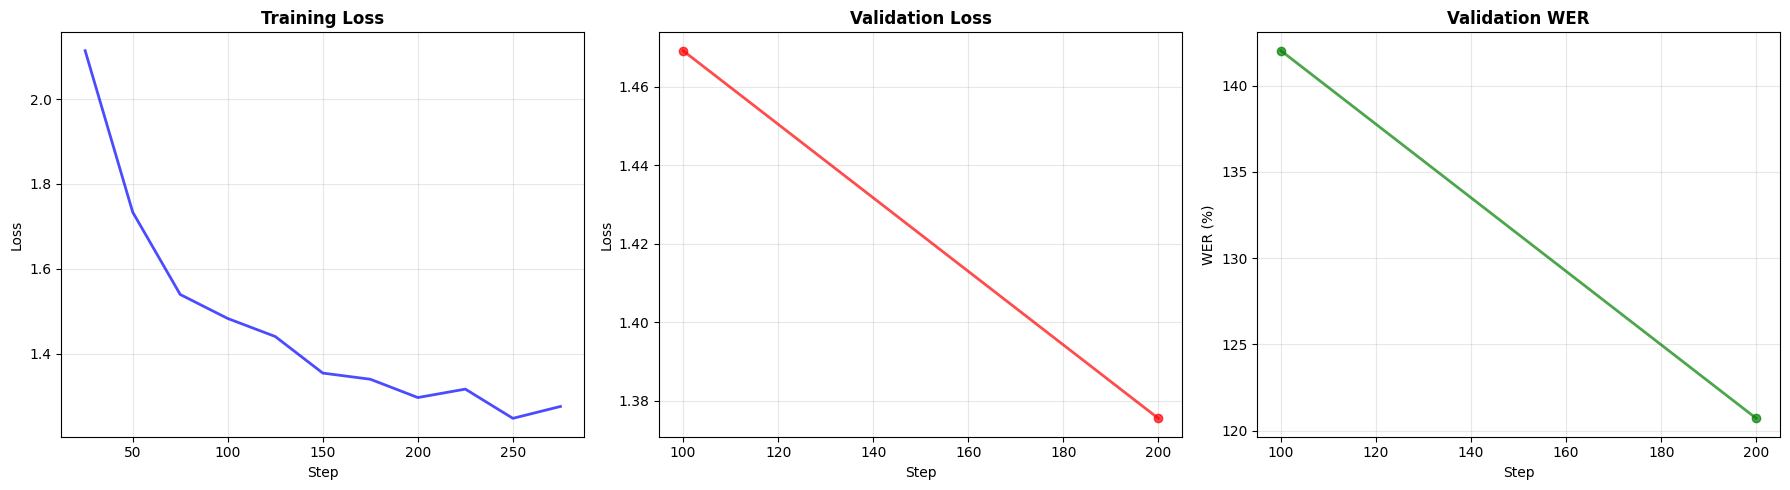

Training curves saved.


In [13]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_losses = [(l['step'], l['loss']) for l in log_history if 'loss' in l]
eval_losses = [(l['step'], l['eval_loss']) for l in log_history if 'eval_loss' in l]
eval_wers = [(l['step'], l['eval_wer']) for l in log_history if 'eval_wer' in l]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

if train_losses:
    steps, losses = zip(*train_losses)
    axes[0].plot(steps, losses, 'b-', alpha=0.7, linewidth=2)
    axes[0].set_xlabel('Step')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss', fontweight='bold')
    axes[0].grid(alpha=0.3)

if eval_losses:
    steps, losses = zip(*eval_losses)
    axes[1].plot(steps, losses, 'r-o', alpha=0.7, linewidth=2)
    axes[1].set_xlabel('Step')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Validation Loss', fontweight='bold')
    axes[1].grid(alpha=0.3)

if eval_wers:
    steps, wers = zip(*eval_wers)
    axes[2].plot(steps, wers, 'g-o', alpha=0.7, linewidth=2)
    axes[2].set_xlabel('Step')
    axes[2].set_ylabel('WER (%)')
    axes[2].set_title('Validation WER', fontweight='bold')
    axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Training curves saved.')

## Step 8: Evaluate on FLEURS Hindi Test Set
Computes the final WER - the value you need for FT Result.xlsx.

In [16]:
from datasets import load_dataset
import jiwer

NUM_EVAL = 200

def evaluate_model(model_to_eval, processor, num_samples=200, label='model'):
    device = next(model_to_eval.parameters()).device
    model_to_eval.eval()

    fleurs_test = load_dataset('google/fleurs', 'hi_in', split='test')
    n = min(num_samples, len(fleurs_test))

    forced_ids = processor.get_decoder_prompt_ids(language='hi', task='transcribe')

    references = []
    predictions = []

    for i in tqdm(range(n), desc=f'Evaluating {label}'):
        sample = fleurs_test[i]
        audio = np.array(sample['audio']['array'], dtype=np.float32)
        sr = sample['audio']['sampling_rate']
        if sr != 16000:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

        input_features = processor(
            audio, sampling_rate=16000, return_tensors='pt'
        ).input_features.to(device)

        with torch.no_grad():
            predicted_ids = model_to_eval.generate(
                input_features,
                forced_decoder_ids=forced_ids,
                max_new_tokens=225,
            )

        pred = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        references.append(sample['transcription'])
        predictions.append(pred)

    wer_val = jiwer.wer(references, predictions)
    cer_val = jiwer.cer(references, predictions)

    return {
        'label': label,
        'corpus_wer': round(wer_val, 4),
        'corpus_cer': round(cer_val, 4),
        'num_samples': n,
        'timestamp': datetime.now().isoformat(),
    }

print('Evaluation function ready.')

Evaluation function ready.


In [17]:
print('Evaluating fine-tuned Whisper on FLEURS Hindi test...')
ft_metrics = evaluate_model(
    model, processor, num_samples=NUM_EVAL, label='FT Whisper Small'
)

print('\nEvaluating pretrained Whisper baseline...')
baseline_model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)
baseline_model.generation_config.language = LANGUAGE
baseline_model.generation_config.task = TASK
device = next(model.parameters()).device
baseline_model = baseline_model.to(device)

baseline_metrics = evaluate_model(
    baseline_model, processor, num_samples=NUM_EVAL,
    label='Whisper Small Pretrained'
)

del baseline_model
torch.cuda.empty_cache()
print('\nEvaluation complete!')

Evaluating fine-tuned Whisper on FLEURS Hindi test...


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Evaluating FT Whisper Small: 100%|██████████| 200/200 [15:44<00:00,  4.72s/it]



Evaluating pretrained Whisper baseline...


Evaluating Whisper Small Pretrained: 100%|██████████| 200/200 [07:47<00:00,  2.34s/it]


Evaluation complete!


## Step 9: YOUR RESULTS - Fill Into FT Result.xlsx

In [18]:
bl_wer = baseline_metrics['corpus_wer']
ft_wer = ft_metrics['corpus_wer']
bl_cer = baseline_metrics['corpus_cer']
ft_cer = ft_metrics['corpus_cer']
improvement = bl_wer - ft_wer

print()
print('=' * 60)
print('  RESULTS FOR FT Result.xlsx')
print('=' * 60)
print()
print(f'  Whisper Small (Pretrained)  WER = {bl_wer:.4f}')
print(f'  FT Whisper Small (yours)    WER = {ft_wer:.4f}  <-- FILL THIS')
print()
print(f'  WER Improvement: {improvement:.4f}')
print(f'  CER: Baseline={bl_cer:.4f}  Fine-tuned={ft_cer:.4f}')
print()
print('=' * 60)
print()
print('  Open FT Result.xlsx and fill in:')
print(f'  Row: FT Whisper Small (yours)')
print(f'  Hindi column: {ft_wer:.4f}')
print()
print('=' * 60)

# Save results
with open(os.path.join(OUTPUT_DIR, 'baseline_metrics.json'), 'w') as f:
    json.dump(baseline_metrics, f, indent=2)
with open(os.path.join(OUTPUT_DIR, 'finetuned_metrics.json'), 'w') as f:
    json.dump(ft_metrics, f, indent=2)

print(f'\nMetrics saved to {OUTPUT_DIR}/')


  RESULTS FOR FT Result.xlsx

  Whisper Small (Pretrained)  WER = 0.6956
  FT Whisper Small (yours)    WER = 1.4858  <-- FILL THIS

  WER Improvement: -0.7902
  CER: Baseline=0.3645  Fine-tuned=1.0091


  Open FT Result.xlsx and fill in:
  Row: FT Whisper Small (yours)
  Hindi column: 1.4858


Metrics saved to /content/outputs/q1/


## Step 10: Download Results

In [19]:
from google.colab import files

for fname in ['finetuned_metrics.json', 'baseline_metrics.json', 'training_curves.png']:
    fpath = os.path.join(OUTPUT_DIR, fname)
    if os.path.exists(fpath):
        files.download(fpath)
        print(f'Downloaded {fname}')

print('\nAll done! Fill the WER value shown above into FT Result.xlsx.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded finetuned_metrics.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded baseline_metrics.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded training_curves.png

All done! Fill the WER value shown above into FT Result.xlsx.


In [20]:
!zip -r outputs.zip outputs/

  adding: outputs/ (stored 0%)
  adding: outputs/q1/ (stored 0%)
  adding: outputs/q1/finetuned_model/ (stored 0%)
  adding: outputs/q1/finetuned_model/special_tokens_map.json (deflated 80%)
  adding: outputs/q1/finetuned_model/config.json (deflated 60%)
  adding: outputs/q1/finetuned_model/training_args.bin (deflated 53%)
  adding: outputs/q1/finetuned_model/preprocessor_config.json (deflated 44%)
  adding: outputs/q1/finetuned_model/tokenizer_config.json (deflated 96%)
  adding: outputs/q1/finetuned_model/generation_config.json (deflated 72%)
  adding: outputs/q1/finetuned_model/model.safetensors (deflated 8%)
  adding: outputs/q1/finetuned_model/checkpoint-290/ (stored 0%)
  adding: outputs/q1/finetuned_model/checkpoint-290/trainer_state.json (deflated 69%)
  adding: outputs/q1/finetuned_model/checkpoint-290/scaler.pt (deflated 64%)
  adding: outputs/q1/finetuned_model/checkpoint-290/config.json (deflated 60%)
  adding: outputs/q1/finetuned_model/checkpoint-290/training_args.bin (de

In [ ]:
!zip -r ft_data.zip ft_data